#Eccentricity & Inclination Damping

For modifying orbital elements, REBOUNDx offers two implementations.  `modify_orbits_direct` directly calculates orbital elements and modifies those, while `modify_orbits_forces` applies forces that when orbit-averaged yield the desired behavior.  We are currently working on a paper that considers when each one might be more appropriate.  We begin importing `rebound` and `reboundx` and setting up a simple simulation of two planets on initially eccentric and inclined orbits:

In [16]:
import rebound
import reboundx
import numpy as np
sim = rebound.Simulation()
ainner = 1.
aouter = 10.
e0 = 0.1
inc0 = 0.1

sim.add(m=1.)
sim.add(m=1e-6,a=ainner,e=e0, inc=inc0)
sim.add(m=1e-6,a=aouter,e=e0, inc=inc0)
sim.move_to_com() # Moves to the center of momentum frame

Now let's set up reboundx and here we choose to add modify_orbits_direct, which calculates orbital elements directly and modifies their values:

In [17]:
rebx = reboundx.Extras(sim)
rebx.add_modify_orbits_direct()

Both `modify_orbits_forces` and `modify_orbits_direct` have a `tau_e` and `tau_inc` member, which are arrays holding the eccentricity and inclination damping(growth) timescales for all the particles in the simulation.  In both cases, a non-zero `tau_e` (`tau_inc`) leads to exponential decay (or growth) of the eccentricity (inclination) with timescale `tau_e` (`tau_inc`), i.e.
\begin{equation}
e = e_0e^{t/\tau_e},\:\:i = i_0e^{t/\tau_i}
\end{equation}
**Thus, negative `tau_e` (`tau_inc`) values correspond to eccentricity (inclination) decay, and positive `tau_e` (`tau_inc`) results in exponential growth.**

In general, each body will have different damping timescales.  The indices in the `tau_e` (`tau_i`) correspond one-to-one with those in the `particles` array in the REBOUND simulation.  A value of 0 represents no migration, and you should not make `tau_e[0]` or `tau_inc[0]` non-zero (the central body does not have an orbit relative to itself).  The units of time are set by the units of time in your simulation.

**Important:** Currently you must only set damping timescales **AFTER** all the particles have been added to the simulation, and this implementation does not support adding or removing particles in the middle of the simulation (e.g. during collisions or particles leaving the box).

Let's set a maximum time for our simulation, and give our two planets different eccentricity and inclination damping timescales:

In [18]:
tmax = 1.e3
tau_es = rebx.modify_orbits_direct.tau_e # nice shortcut so we don't have to keep typing the long name
tau_incs = rebx.modify_orbits_direct.tau_inc
tau_es[1] = -tmax/10.  # this is for particles[1]
tau_es[2] = -tmax      # this is for particles[2]
tau_incs[1] = -tmax/10.  
tau_incs[2] = -tmax      

Now we simply run the simulation like we would normally with REBOUND.  Here we store the semimajor axes at 1000 equally spaced intervals:

In [19]:
Nout = 1000
e1,e2,inc1,inc2 = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
times = np.linspace(0.,tmax,Nout)
for i,time in enumerate(times):
    sim.integrate(time)
    orbits = sim.calculate_orbits() # returns an array of orbits, where the 0 element is the first *PLANET*
    e1[i] = orbits[0].e
    e2[i] = orbits[1].e
    inc1[i] = orbits[0].inc
    inc2[i] = orbits[1].inc

Now let's plot it on a linear-log scale to check whether we get the expected exponential behavior.  We'll also overplot the expected exponential decays for comparison.

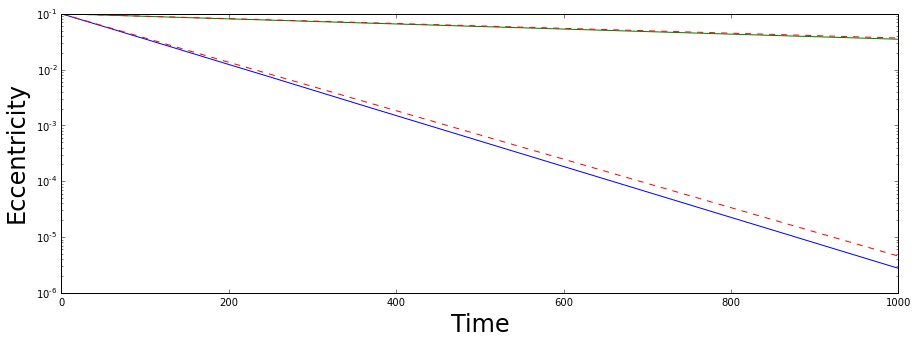

In [20]:
e1pred = [e0*np.e**(t/tau_es[1]) for t in times]
e2pred = [e0*np.e**(t/tau_es[2]) for t in times]

%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.set_yscale('log')
plt.plot(times,e1)
plt.plot(times,e1pred, 'r--')
plt.plot(times,e2)
plt.plot(times,e2pred, 'r--')
plt.axes().set_xlabel("Time", fontsize=24)
plt.axes().set_ylabel("Eccentricity", fontsize=24)

Hm...I'm looking into this behavior.  Plotting the semimajor axes,

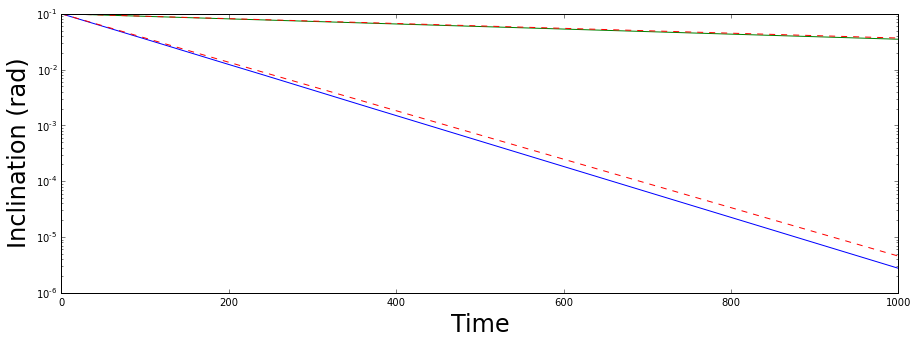

In [21]:
inc1pred = [inc0*np.e**(t/tau_incs[1]) for t in times]
inc2pred = [inc0*np.e**(t/tau_incs[2]) for t in times]

%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.set_yscale('log')
plt.plot(times,inc1)
plt.plot(times,inc1pred, 'r--')
plt.plot(times,inc2)
plt.plot(times,inc2pred, 'r--')
plt.axes().set_xlabel("Time", fontsize=24)
plt.axes().set_ylabel("Inclination (rad)", fontsize=24)

**Eccentricity-semimajor axis coupling**

Goldreich & Schlichting (2014) argue that a physical process that induces eccentricity damping should induce semimajor axis damping at order $e^2$, e.g., tides.  We follow the Deck & Batygin (2015) of parametrizing this through a coefficient $p$ that varies between 0 and 1.  p=0 corresponds to no coupling, while p=1 represents the limit of eccentricity damping at constant angular momentum, which to a good approximation is the case with tides (our p=1 therefore corresponds to Golreich and Schlichting's p=3).  To set p with `modify_orbits_direct`:

In [22]:
rebx.modify_orbits_direct.e_damping_p = 0.7

The default is `e_damping_p = 0`, i.e., no coupling, so for a single planet, if you don't set `tau_a`, the planet will not migrate.  The `modify_orbits_forces` implementation always damps eccentricity at constant angular momentum, i.e., p=1 (though you do not have to set it).